## LangChain Agents: Complete Guide

This notebook demonstrates three different approaches to creating LangChain agents:
1. **Basic Agent with Model String** - Simplest approach for quick prototyping
2. **Agent with Explicit Model Instance** - Full control over model configuration
3. **Dynamic Model Selection** - Cost optimization with automatic model switching

## Prerequisites

Make sure you have the required packages installed and Ollama running:

```bash
pip install -U langchain langchain-community langchain-core langgraph
pip install -U ddgs python-dotenv
```

Local LLM Serving with Ollama:
```bash
ollama pull qwen3
ollama pull gpt-oss
ollama serve
```

In [ ]:
# pip install -U langchain langchain-community langchain-core langgraph
# pip install -U ddgs python-dotenv

---
## 1. Agent with Explicit Model Instance

Full control over model configuration by creating an explicit ChatOllama instance.

## Model Parameters Explained
- **temperature**: Controls randomness (0.0 = deterministic, 1.0 = very creative)
- **num_predict**: Maximum tokens to generate (similar to max_tokens in OpenAI)
- **top_k**: Number of highest probability tokens to consider
- **top_p**: Cumulative probability threshold for token selection
- **repeat_penalty**: Penalty for repeating tokens
- **num_ctx**: Context window size

In [1]:
# Import required modules
from langchain.agents import create_agent
from langchain_ollama import ChatOllama
import tools

In [2]:
# Test the web search tool
print(tools.web_search.invoke("python programming"))

Search Results for 'python programming':


1. **Python (programming language)**
   Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation. Python is dynamically type-checked and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language. Python 3.0, released in 2008, was a major revision and not completely backward-compatible with earlier versions. Recent versions, such as Python 3.13, 3.12 and older (and 3.14), have added capabilities and keywords for typing, helping with (optional) static typing. Currently only versions in the 3.x series are supported. Python consistently ranks as one of the most popular programming languages, and it has gained widespread use in the machine learning communi

In [5]:
# Define system prompt to use across all agents
system_prompt = """You are a helpful AI assistant. 
Use the available tools when needed to answer questions accurately.
If you need to search for information, use the web_search tool.
Always provide clear and concise answers."""

In [5]:
# Create model instance with custom parameters
model = ChatOllama(
    model="qwen3",
    base_url="http://localhost:11434",
    temperature=0
)

In [6]:
# Create agent with explicit model instance and system prompt
agent = create_agent(
    model, 
    tools=[tools.web_search],
    system_prompt=system_prompt
)

In [7]:
# Test the agent with a mathematical calculation
result = agent.invoke({
    "messages": "What is the top global news headline right now?"
})

print(f"Response: {result['messages'][-1].content}")

Response: The top global news headline currently revolves around **Amazon Web Services (AWS) outage**, which disrupted dozens of platforms, including Canva and Snapchat, for over 15 hours. Cybersecurity experts warn of potential scams due to the outage. 

Other significant headlines include:
1. **Pope Leo meeting clergy abuse survivors** at the Vatican, emphasizing zero-tolerance policies.
2. **BBC Sounds** providing live global news updates.
3. **South Africa's news** from TimesLIVE, covering local and international developments.

For real-time updates, checking official news outlets like BBC or Reuters is recommended.


In [8]:
# View full result
result

{'messages': [HumanMessage(content='What is the top global news headline right now?', additional_kwargs={}, response_metadata={}, id='fe34f995-8bbf-4f09-a5dd-c68bcea88440'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T10:08:34.3650282Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3411434300, 'load_duration': 1558013000, 'prompt_eval_count': 242, 'prompt_eval_duration': 46203200, 'eval_count': 330, 'eval_duration': 1725118300, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--fb4cdbc8-d1ae-4879-91f9-e437c832955d-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 1, 'query': 'current top global news headline'}, 'id': '26cbb9a6-4632-4a9a-8fd4-a8b6e32eb9f8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 330, 'total_tokens': 572}),
  ToolMessage(content="Search Results for 'current top global news headline':\n\n\n1. **Internet pricing - AT&T Community Forums*

In [9]:
# Pretty print the last message
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

The top global news headline currently revolves around **Amazon Web Services (AWS) outage**, which disrupted dozens of platforms, including Canva and Snapchat, for over 15 hours. Cybersecurity experts warn of potential scams due to the outage. 

Other significant headlines include:
1. **Pope Leo meeting clergy abuse survivors** at the Vatican, emphasizing zero-tolerance policies.
2. **BBC Sounds** providing live global news updates.
3. **South Africa's news** from TimesLIVE, covering local and international developments.

For real-time updates, checking official news outlets like BBC or Reuters is recommended.


### Experimenting with Different Settings

Let's compare different model configurations to see how they affect the output:

In [ ]:
question = "Explain what 2 + 2 equals and show your reasoning"

# Configuration 1: Conservative/Deterministic
llm1 = ChatOllama(
    model="qwen3",
    temperature=0,
    top_p=1,
    repeat_penalty=1.1,
    num_predict=500,
    num_ctx=4096,
    reasoning=True
)
agent = create_agent(llm1, tools=[tools.calculate], system_prompt=system_prompt)
result = agent.invoke({"messages": question})
print(f"Conservative output: {result['messages'][-1].content}")
print()

In [ ]:
# Configuration 2: Balanced/Production
llm = ChatOllama(
    model="qwen3",
    temperature=2,
    top_k=2000,
    repeat_penalty=1.15,
    repeat_last_n=64,
    num_predict=1000,
    num_ctx=8192,
    keep_alive="5m",
    reasoning=False
)

agent = create_agent(llm, tools=[tools.calculate], system_prompt=system_prompt)
result = agent.invoke({"messages": question})
print(result['messages'][-1].content)
print()

## 2. Dynamic Model Selection (Qwen3 → GPT-OSS)

Cost-optimization strategy where the agent automatically switches between models based on conversation complexity.

## Selection Logic
- **< 10 messages**: Use Qwen3 (fast, efficient)
- **≥ 10 messages**: Use GPT-OSS (better reasoning, longer context)

## Real-World Applications
- Customer service bots (simple queries → Qwen3, complex issues → GPT-OSS)
- Research assistants (quick facts → Qwen3, analysis → GPT-OSS)

In [1]:
# Import required modules
from langchain_ollama import ChatOllama
from langchain.agents import create_agent, AgentState
from langgraph.runtime import Runtime
import tools

llm = ChatOllama(
    model="qwen3",
    temperature=0,
    base_url="http://localhost:11434"
).bind_tools([tools.web_search])

llm.invoke('What are the global news headlines today?')

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T10:17:22.5623237Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1235727200, 'load_duration': 67631400, 'prompt_eval_count': 201, 'prompt_eval_duration': 210404900, 'eval_count': 175, 'eval_duration': 925094500, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--d7f82b12-1c0b-4ff5-a4c4-a029291cddcc-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 10, 'query': "today's global news headlines"}, 'id': '918930ac-d966-47a2-9d04-812ae3943a43', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 175, 'total_tokens': 376})

## Model Selection Function

This function automatically chooses between Qwen3 and GPT-OSS based on conversation length:

In [2]:
# Define tool list for both models
tool_list = [tools.web_search]

def select_model(state: AgentState, runtime: Runtime) -> ChatOllama:
    """Choose between Qwen3 and GPT-OSS based on conversation length."""
    messages = state["messages"]
    message_count = len(messages)
    
    if message_count < 10:
        print(f"Using Qwen3 for {message_count} messages")
        llm = ChatOllama(
            model="qwen3",
            temperature=0.1,
            base_url="http://localhost:11434"
        )
        return llm.bind_tools(tool_list)
    
    else:
        print(f"Switching to GPT-OSS for {message_count} messages")
        llm = ChatOllama(
            model="gpt-oss",
            temperature=0.0,
            num_predict=2000,
            base_url="http://localhost:11434"
        )
        return llm.bind_tools(tool_list)


## Creating the Dynamic Agent

Create an agent that uses our dynamic model selection function:

In [6]:
# Create agent with dynamic model selection and system prompt
agent = create_agent(
    select_model, 
    tools=tool_list,
    system_prompt=system_prompt
)

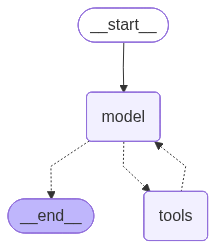

In [7]:
agent

In [ ]:
agent.invoke({"messages": "What is the capital of France?"})

AttributeError: 'function' object has no attribute 'bind_tools'

In [10]:
def demo_conversation_progression(messages):
    """Demonstrate how the agent switches models as conversation grows."""
        
    # Create a mock state to test model selection
    mock_state = {"messages": messages}
    
    agent = create_agent(select_model, tools=tool_list, system_prompt=system_prompt)
    result = agent.invoke(mock_state)

    return result

messages = [
        "Hello", "How are you?", "What's the weather?", "My name is Laxmi Kant Tiwari",
        "Explain machine learning", "What about deep learning?", "Show me examples",
        "How does this work?", "Give me more details"]

print(f"Len of messages: {len(messages)}")

result = demo_conversation_progression(messages)

Len of messages: 9


AttributeError: 'function' object has no attribute 'bind_tools'

In [11]:
messages = [
        "Hello", "How are you?", "What's the weather?", "My name is Laxmi Kant Tiwari",
        "Explain machine learning", "What about deep learning?", "Show me examples",
        "How does this work?", "Give me more details", "What is my name? and summarize my previous questions"]

print(f"Len of messages: {len(messages)}")

result = demo_conversation_progression(messages)

Len of messages: 10


AttributeError: 'function' object has no attribute 'bind_tools'